In [75]:
%load_ext autoreload
%autoreload 2
from mmcontext.utils import setup_logging

logger = setup_logging()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
from datasets import load_dataset

dataset = load_dataset("jo-mengr/cellxgene_pseudo_bulk_3_5k_multiplets_cell_type_cs50")

In [ ]:
from sentence_transformers import SentenceTransformer

from mmcontext.models.mmcontextencoder import MMContextEncoder

enc = MMContextEncoder(
    "NeuML/pubmedbert-base-embeddings",
    adapter_hidden_dim=None,
    adapter_output_dim=None,
    output_token_embeddings=False,
    freeze_text_encoder=True,
    train_lookup=False,
)

2025-07-08 12:48:22,512 - mmcontext.file_utils - INFO - Found 2 unique share links across ['train', 'val'] splits
Processing: 100%|██████████| 2/2 [00:00<00:00, 5077.85file/s]
2025-07-08 12:48:22,516 - mmcontext.file_utils - INFO - Reading /Users/mengerj/repos/mmcontext/data/from_nxtcloud/chunk_0.zarr
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_hvg' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_scvi_fm' was written without encoding metadata.
  return self.

Use the returned DataFrame to register the embeddings with `register_initial_embeddings()`.


In [ ]:
st = SentenceTransformer("NeuML/pubmedbert-base-embeddings")
# st = SentenceTransformer("jo-mengr/mmcontext-cg_100k-cell_type-pubmedbert-None-text_only_50-feat_cs")

2025-07-08 12:42:06,886 - sentence_transformers.SentenceTransformer - INFO - Use pytorch device_name: mps
2025-07-08 12:42:06,886 - sentence_transformers.SentenceTransformer - INFO - Load pretrained SentenceTransformer: NeuML/pubmedbert-base-embeddings


In [80]:
# enc.register_initial_embeddings(token_df, data_origin="geneformer")
dataset_ready = enc.prepare_ds(dataset, primary_cell_sentence_col="cell_sentence_1", prefix=False)

/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/datasets/utils/_dill.py:385: DeprecationWarning: co_lnotab is deprecated, use co_lines instead.
  obj.co_lnotab,  # for < python 3.10 [not counted in args]
Resolving negative indices: 100%|██████████| 59/59 [00:00<00:00, 23449.63 examples/s]


In [ ]:
from mmcontext.file_utils import load_test_adata_from_hf_dataset, subset_dataset_by_chunk

adata, local_path = load_test_adata_from_hf_dataset(dataset["train"], save_dir="../../data/from_nxtcloud/train")
adata, train_sub = subset_dataset_by_chunk(adata, dataset["train"])

2025-07-08 12:48:42,676 - mmcontext.file_utils - INFO - Found 1 unique share links across ['test'] splits
2025-07-08 12:48:42,676 - mmcontext.file_utils - INFO - Picked share-link https://nxc-fredato.imbi.uni-freiburg.de/s/tp4jHqYyRmCHnSs (out of 1)
Processing: 100%|██████████| 1/1 [00:00<00:00, 7449.92file/s]
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_geneformer' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_hvg' was written without encoding metadata.
  return self.callback(read_func, elem.name, elem, iospec=iospec)
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/anndata/_io/specs/registry.py:281: OldFormatWarning: Element '/obsm/X_scvi_fm' was written without encoding metadata.
  ret

In [65]:
dataset_train = dataset_ready["train"]

In [72]:
if "sentence_1" in dataset_train.column_names:
    omics_embeddings = st.encode(dataset_train["sentence_1"])
if "anchor" in dataset_train.column_names:
    omics_embeddings = st.encode(dataset_train["anchor"])
if "sentence_2" in dataset_train.column_names:
    text_embeddings = st.encode(dataset_train["sentence_2"])
if "positive" in dataset_train.column_names:
    text_embeddings = st.encode(dataset_train["positive"])
adata.obsm["mmcontext_emb"] = omics_embeddings
adata.obsm["text_emb"] = text_embeddings

Batches: 100%|██████████| 73/73 [00:00<00:00, 96.37it/s] 


In [73]:
from mmcontext.eval.utils import create_emb_pair_dataframe

emb_pair_df = create_emb_pair_dataframe(
    adata,
    embedding_dict={"omics": "mmcontext_emb", "text": "text_emb"},
    subset_size=20,
    label_keys=["dataset_title", "cell_type"],
)

/Users/mengerj/repos/mmcontext/src/mmcontext/eval/utils.py:208: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  row[label_key] = adata.obs[label_key][sampled_indices[idx]]
2025-07-08 12:42:19,462 - mmcontext.eval.utils - INFO - Created DataFrame with 40 rows (20 samples × 2 modalities)


2025-07-08 12:42:19,490 - mmcontext.pl.plotting - WARNING - Requested n_samples (50) is greater than total unique sample_ids (20). Using all sample_ids instead.
2025-07-08 12:42:19,491 - mmcontext.pl.plotting - INFO - Applying UMAP to subset of size=40 with metric=cosine...
/Users/mengerj/repos/mmcontext/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


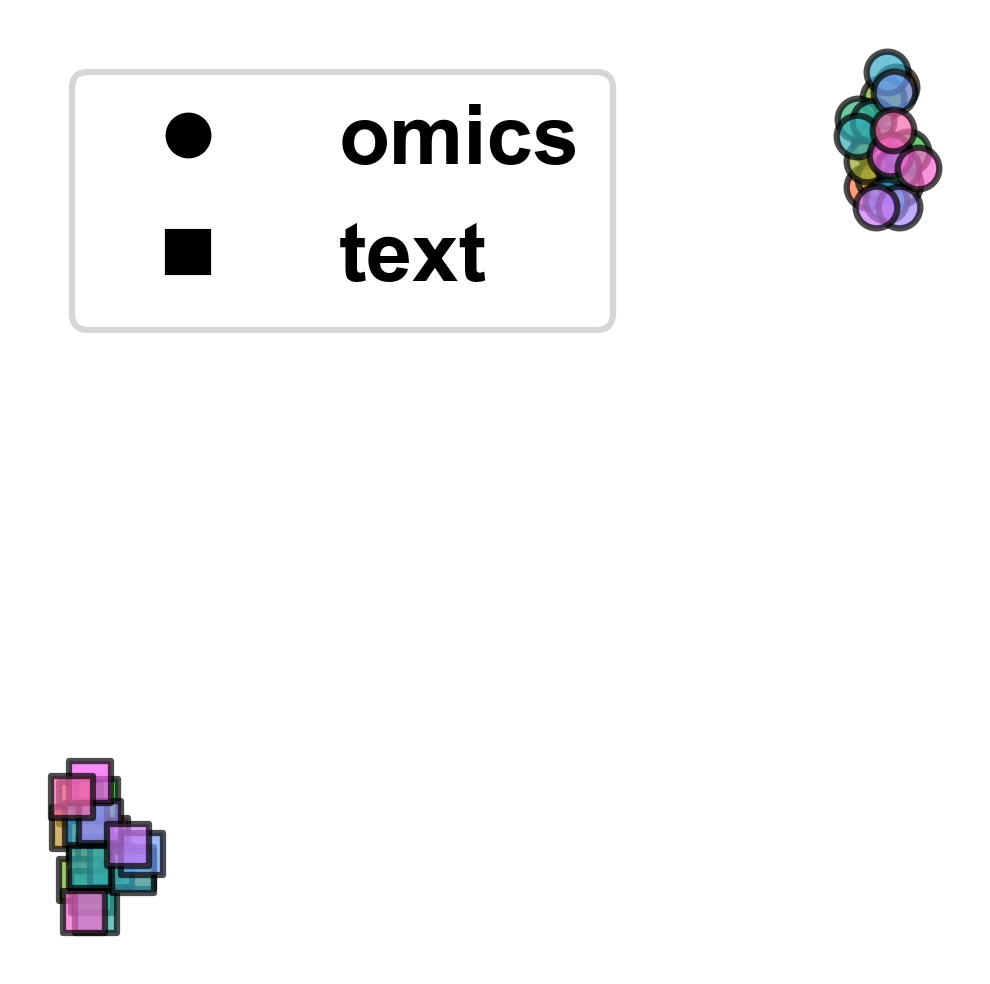

2025-07-08 12:42:19,590 - mmcontext.pl.plotting - INFO - Displayed embedding clusters interactively.


In [74]:
from mmcontext.pl import visualize_embedding_clusters

visualize_embedding_clusters(
    emb_pair_df,
    method="umap",
    metric="cosine",
    n_neighbors=15,
    min_dist=0.1,
    figsize=(4, 4),
    random_state=42,
    point_size=100,
    legend_fontsize=20,
)